## Music Evaluation

In [2]:
import json
from argparse import ArgumentParser
import midi
import glob
import copy
import os
import numpy as np
import pretty_midi
from pprint import pprint
import pickle
from mgeval.mgeval import core, utils
from sklearn.model_selection import LeaveOneOut

In [159]:
# midi file이 들어있는 folder path를 넣어주세요!

'''
ToDo
1. Classic, pop real data VS MT_model
2. MT_model VS MT_only
3. MT_only VS CTRL_model
'''

# dataset
classic = '/home/bang/다운로드/maestro-v2.0.0-midi/maestro_midi'
pop = '/home/bang/PycharmProjects/POP909-Dataset/pop909_midi'

# MT_model
#    classic : (classic + pop) training + classic primer + no condition token
#    pop     : (classic + pop) training + pop primer + no condition token
MT_classic = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/MT_classic_pop_none/classic'
MT_pop = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/MT_classic_pop_none/pop'

# only_model
#   classic only : classic training + classic primer
#   pop only     : pop training + pop primer
MT_classic_only = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/MT_classic_none/classic'
MT_pop_only = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/MT_pop_none/pop'

# CTRL
#    classic (condition) : classic + pop training + classic condition token + classic primer
#    pop (condition)     : classic + pop training + pop condition token + pop primer
MT_CTRL_classic1 = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/CTRL/default_token/classic'
MT_CTRL_classic2 = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/CTRL/reverse_token/pop'
MT_CTRL_pop1 = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/CTRL/default_token/pop'
MT_CTRL_pop2 = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/CTRL/reverse_token/classic'


In [160]:
set1 = glob.glob(os.path.join(classic, '*'))
set2 = glob.glob(os.path.join(pop, '*'))

set3 = glob.glob(os.path.join(MT_CTRL_classic1, '*')) + glob.glob(os.path.join(MT_CTRL_classic2, '*'))
set4 = glob.glob(os.path.join(MT_CTRL_pop1, '*')) + glob.glob(os.path.join(MT_CTRL_pop2, '*'))

## Number of samples

- set1: classic midi files
- set2: pop midi files

In [161]:
print("set1 size :", len(set2), ", set2 size :", len(set4))

set1 size : 909 , set2 size : 2191


In [162]:
num_samples = min(len(set2), len(set4))

## metrics

- total used pitch
- pitch_range
- avg pitch shift
- avg IOI
- total_pitch class histogram

In [163]:
evalset = { 
            'total_used_pitch': np.zeros((num_samples, 1))
          , 'pitch_range': np.zeros((num_samples, 1))
          , 'avg_pitch_shift': np.zeros((num_samples, 1))
          , 'avg_IOI': np.zeros((num_samples, 1))
          , 'pitch_MAX':np.zeros((num_samples, 1))
          , 'pitch_MIN':np.zeros((num_samples, 1))
          #, 'total_used_note': np.zeros((num_samples, 1))
          # , 'bar_used_pitch': np.zeros((num_samples, args.num_bar, 1))
          # , 'bar_used_note': np.zeros((num_samples, args.num_bar, 1))
          , 'total_pitch_class_histogram': np.zeros((num_samples, 12))
          # , 'bar_pitch_class_histogram': np.zeros((num_samples, args.num_bar, 12))
          , 'note_length_hist': np.zeros((num_samples, 12))
          , 'pitch_class_transition_matrix': np.zeros((num_samples, 12, 12))
          , 'note_length_transition_matrix': np.zeros((num_samples, 12, 12))
          }

In [164]:
metrics_list = list(evalset.keys())

single_arg_metrics = (
    [ 'total_used_pitch'
    , 'avg_IOI'
    , 'total_pitch_class_histogram'
    , 'pitch_range'
    , 'pitch_MAX'
    , 'pitch_MIN'
    ])

set1_eval = copy.deepcopy(evalset)
set2_eval = copy.deepcopy(evalset)

set3_eval = copy.deepcopy(evalset)
set4_eval = copy.deepcopy(evalset)

sets1 = [ (set1, set1_eval), (set2, set2_eval) ]
sets2 = [ (set3, set3_eval), (set4, set4_eval) ]

## 모든 트랙에 대해서 계산하는 평가지표

In [165]:
def pitch_MAX(feature):
    piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
    pitch_index = np.where(np.sum(piano_roll, axis=1) > 0)
    return np.max(pitch_index)

def pitch_MIN(feature):
    piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
    pitch_index = np.where(np.sum(piano_roll, axis=1) > 0)
    return np.min(pitch_index)

In [166]:
def total_pitch_class_histogram_All_instruments(feature):
    """
    total_pitch_class_histogram (Pitch class histogram):
    The pitch class histogram is an octave-independent representation of the pitch content with a dimensionality of 12 for a chromatic scale.
    In our case, it represents to the octave-independent chromatic quantization of the frequency continuum.

    Returns:
    'histogram': histrogram of 12 pitch, with weighted duration shape 12
    """
    
    instrument_num = len(feature['pretty_midi'].instruments)
    piano_roll_list = []
    for i in range(instrument_num):
        piano_roll = feature['pretty_midi'].instruments[i].get_piano_roll(fs=100)
        piano_roll_list.append(piano_roll)
    
    histogram = np.zeros(12)
    for i in range(0, 128):
        pitch_class = i % 12
        for piano_roll_temp in piano_roll_list:
            histogram[pitch_class] += np.sum(piano_roll_temp, axis=1)[i]
    histogram = histogram / sum(histogram)
    return histogram

In [167]:
def pitch_range_All_instruments(feature):
    """
    pitch_range (Pitch range):
    The pitch range is calculated by subtraction of the highest and lowest used pitch in semitones.

    Returns:
    'p_range': a scalar for each sample.
    """
    
    instrument_num = len(feature['pretty_midi'].instruments)
    cnt_pitch_temp = []
    for i in range(instrument_num):
        piano_roll = feature['pretty_midi'].instruments[i].get_piano_roll(fs=100)
        cnt_pitch_temp.append(np.sum(piano_roll, axis=1))

    pitch_index = np.where(np.sum(cnt_pitch_temp, axis=0) > 0)

    p_range = np.max(pitch_index) - np.min(pitch_index)
    

    return p_range

In [168]:
def total_used_note_All_instruments(feature):
    """
    total_used_note (Note count): The number of used notes.
    As opposed to the pitch count, the note count does not contain pitch information but is a rhythm-related feature.

    Args:
    'track_num' : specify the track number in the midi pattern, default is 1 (the second track).

    Returns:
    'used_notes': a scalar for each sample.
    """
    
    pattern = feature['midi_pattern']
    
    temp = []
    for i in range(len(pattern)):
        temp.extend(pattern[i])
    
    pattern = temp
    
    used_notes = 0
    for i in range(0, len(pattern)):
        if type(pattern[i]) == midi.events.NoteOnEvent and pattern[i].data[1] != 0:
            used_notes += 1
    return used_notes

In [169]:
def avg_pitch_shift_All_instruments(feature):
    """
    avg_pitch_shift (Average pitch interval):
    Average value of the interval between two consecutive pitches in semitones.

    Args:
    'track_num' : specify the track number in the midi pattern, default is 1 (the second track).

    Returns:
    'pitch_shift': a scalar for each sample.
    """
    pattern = feature['midi_pattern']
    pattern.make_ticks_abs()
    resolution = pattern.resolution
    total_used_note_value = total_used_note_All_instruments(feature)
    d_note = np.zeros((max(total_used_note_value - 1, 0)))
    # if total_used_note_value == 0:
      # return 0
    # d_note = np.zeros((total_used_note_value - 1))
    
    # 여러 트랙을 하나로 합쳐줌
    pattern = feature['midi_pattern']
    temp = []
    for i in range(len(pattern)):
        temp.extend(pattern[i])
    pattern = temp
    
    current_note = 0
    counter = 0
    for i in range(0, len(pattern)):
        if type(pattern[i]) == midi.events.NoteOnEvent and pattern[i].data[1] != 0:
            if counter != 0:
                d_note[counter - 1] = current_note - pattern[i].data[0]
                current_note = pattern[i].data[0]
                counter += 1
            else:
                current_note = pattern[i].data[0]
                counter += 1
    pitch_shift = np.mean(abs(d_note))
    return pitch_shift

## 평가 진행(30분정도 소요됩니다)

In [139]:
# Extract Fetures
for _set, _set_eval in sets1:
    for i in range(0, num_samples):
        feature = core.extract_feature(_set[i])
        for metric in metrics_list:
            if metric == 'pitch_range':
                evaluator = pitch_range_All_instruments
            elif metric == 'total_pitch_class_histogram':
                evaluator = total_pitch_class_histogram_All_instruments
            elif metric == 'avg_pitch_shift':
                evaluator = avg_pitch_shift_All_instruments
            elif metric == 'pitch_MAX':
                evaluator = pitch_MAX
            elif metric == 'pitch_MIN':
                evaluator = pitch_MIN
            else:
                evaluator = getattr(core.metrics(), metric)
                
            if metric in single_arg_metrics or metric == 'avg_pitch_shift':
                tmp = evaluator(feature)
            # elif metric in bar_metrics:
            #     # print(metric)
            #     tmp = evaluator(feature, 0, args.num_bar)
            # print(tmp.shape)
            elif metric == 'pitch_class_transition_matrix':
                tmp = evaluator(feature, normalize=1)
            else:
                tmp = evaluator(feature, 1)
            _set_eval[metric][i] = tmp
            
# Extract Fetures
for _set, _set_eval in sets2:
    for i in range(0, num_samples):
        feature = core.extract_feature(_set[i])
        for metric in metrics_list:
            if metric == 'pitch_range':
                evaluator = pitch_range_All_instruments
            elif metric == 'total_pitch_class_histogram':
                evaluator = total_pitch_class_histogram_All_instruments
            elif metric == 'avg_pitch_shift':
                evaluator = avg_pitch_shift_All_instruments
            elif metric == 'pitch_MAX':
                evaluator = pitch_MAX
            elif metric == 'pitch_MIN':
                evaluator = pitch_MIN
            else:
                evaluator = getattr(core.metrics(), metric)
                
            if metric in single_arg_metrics or metric == 'avg_pitch_shift':
                tmp = evaluator(feature)
            # elif metric in bar_metrics:
            #     # print(metric)
            #     tmp = evaluator(feature, 0, args.num_bar)
            # print(tmp.shape)
            elif metric == 'pitch_class_transition_matrix':
                tmp = evaluator(feature, normalize=1)
            else:
                tmp = evaluator(feature, 1)
            _set_eval[metric][i] = tmp

## 평가 결과

### 수치로 평가를 확인합시다

In [151]:
set1_TUP = (set3_eval['total_used_pitch']).sum(-1).mean()
set2_TUP = (set4_eval['total_used_pitch']).sum(-1).mean()

print("set1 total used pitch :", set1_TUP)
print("set2 total used pitch :", set2_TUP)

set1 total used pitch : 34.98679867986799
set2 total used pitch : 34.07480748074808


In [152]:
set1_TCU = (set3_eval['total_pitch_class_histogram']!=0).sum(-1).mean()
set2_TCU = (set4_eval['total_pitch_class_histogram']!=0).sum(-1).mean()

print("set1_TCU :", set1_TCU)
print("set2_TCU :", set2_TCU)

set1_TCU : 10.491749174917492
set2_TCU : 10.293729372937294


In [156]:
set1_PR = (set3_eval['pitch_MAX']).mean()
set2_PR = (set4_eval['pitch_MAX']).mean()

print("set1_PR :", set1_PR)
print("set2_PR :", set2_PR)

set1_PR : 86.4048404840484
set2_PR : 85.74807480748075


In [154]:
set1_APS = set3_eval['avg_pitch_shift'].sum(-1).mean()
set2_APS = set4_eval['avg_pitch_shift'].sum(-1).mean()

print("set1_APS :", set1_APS)
print("set2_APS :", set2_APS)

set1_APS : 10.215087409276844
set2_APS : 10.277779284403469


In [157]:
set1_IOI = set1_eval['avg_IOI'].sum(-1).mean()
set2_IOI = set2_eval['avg_IOI'].sum(-1).mean()

print("set1_IOI :", set1_IOI)
print("set2_IOI :", set2_IOI)

set1_IOI : 0.14713542126361126
set2_IOI : 0.14975032287403311


### 시각화하여 통계를 확인합시다

In [145]:
import matplotlib.pyplot as plt;
import seaborn as sns

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

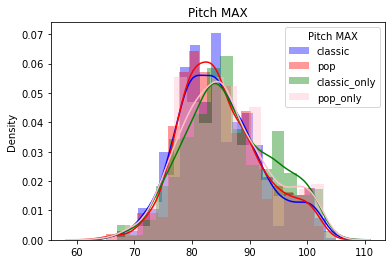

In [146]:
sns.distplot(set1_eval['pitch_MAX'], color='blue', label='classic')
sns.distplot(set2_eval['pitch_MAX'], color='red', label='pop')
sns.distplot(set3_eval['pitch_MAX'], color='green', label='classic_only')
sns.distplot(set4_eval['pitch_MAX'], color='pink', label='pop_only')

plt.title("Pitch MAX")
plt.legend(title='Pitch MAX');
plt.savefig('Pitch_MAX.png', dpi=300)
plt.show();

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

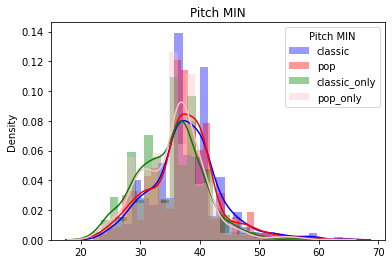

In [147]:
sns.distplot(set1_eval['pitch_MIN'], color='blue', label='classic')
sns.distplot(set2_eval['pitch_MIN'], color='red', label='pop')
sns.distplot(set3_eval['pitch_MIN'], color='green', label='classic_only')
sns.distplot(set4_eval['pitch_MIN'], color='pink', label='pop_only')

plt.title("Pitch MIN")
plt.legend(title='Pitch MIN');
plt.savefig('Pitch_MIN.png', dpi=300)
plt.show();

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

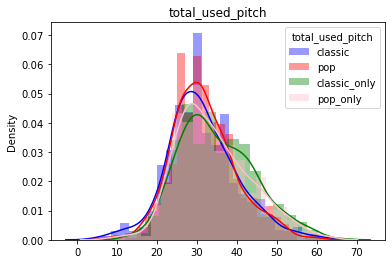

In [148]:
sns.distplot(set1_eval['total_used_pitch'], color='blue', label='classic')
sns.distplot(set2_eval['total_used_pitch'], color='red', label='pop')
sns.distplot(set3_eval['total_used_pitch'], color='green', label='classic_only')
sns.distplot(set4_eval['total_used_pitch'], color='pink', label='pop_only')

plt.title("total_used_pitch")
plt.legend(title='total_used_pitch')
plt.savefig('total_used_pitch.png', dpi=300)
plt.show()

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

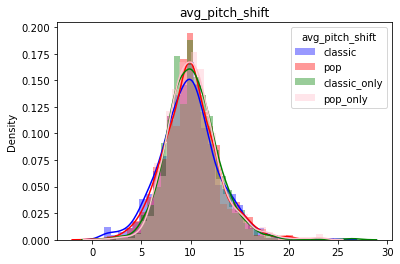

In [149]:
sns.distplot(set1_eval['avg_pitch_shift'], color='blue', label='classic')
sns.distplot(set2_eval['avg_pitch_shift'], color='red', label='pop')
sns.distplot(set3_eval['avg_pitch_shift'], color='green', label='classic_only')
sns.distplot(set4_eval['avg_pitch_shift'], color='pink', label='pop_only')

plt.title("avg_pitch_shift")
plt.legend(title='avg_pitch_shift')
plt.savefig('avg_pitch_shift.png', dpi=300)
plt.show()

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

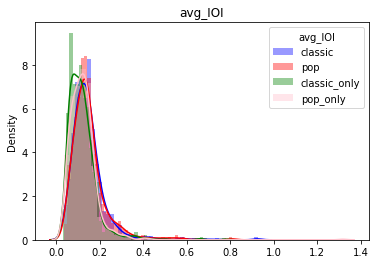

In [150]:
sns.distplot(set1_eval['avg_IOI'], color='blue', label='classic')
sns.distplot(set2_eval['avg_IOI'], color='red', label='pop')
sns.distplot(set3_eval['avg_IOI'], color='green', label='classic_only')
sns.distplot(set4_eval['avg_IOI'], color='pink', label='pop_only')

plt.title("avg_IOI")
plt.legend(title='avg_IOI')
plt.savefig('avg_IOI.png', dpi=300)
plt.show()

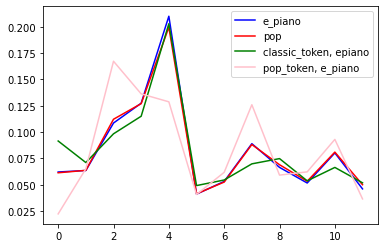

In [77]:
plt.plot(set1_eval['note_length_hist'].mean(0), color = 'blue', label = 'e_piano')
plt.plot(set2_eval['note_length_hist'].mean(0), color='red', label = 'pop')
plt.plot(set3_eval['note_length_hist'].mean(0), color='green', label = 'classic_token, epiano')
plt.plot(set4_eval['note_length_hist'].mean(0), color='pink', label = 'pop_token, e_piano')
plt.legend(title='note_length_hist')
plt.legend()
plt.show()

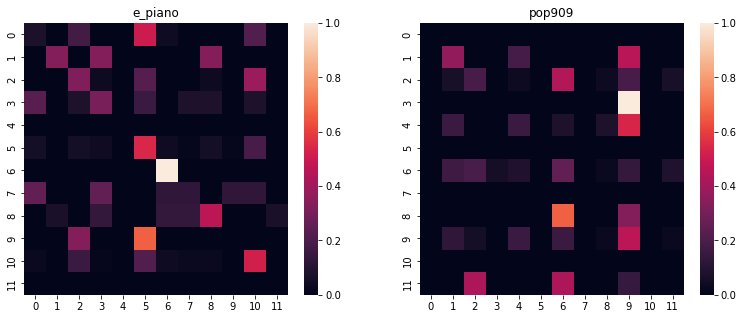

In [181]:
plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.title("e_piano")
sns.heatmap(data = set1_eval['pitch_class_transition_matrix'][80])
plt.subplot(1, 2, 2)
plt.title("pop909")
sns.heatmap(data = set2_eval['pitch_class_transition_matrix'][80])


plt.show()

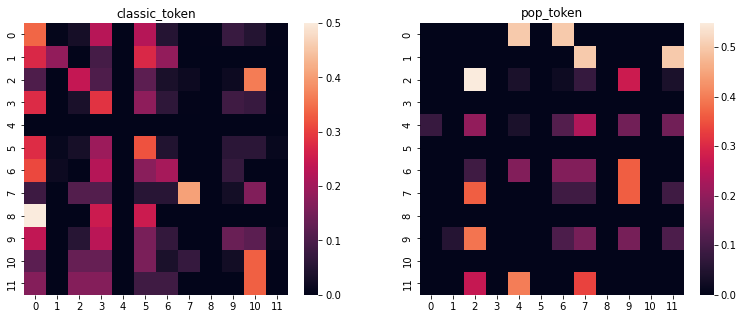

In [182]:
plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.title("classic_token")
sns.heatmap(data = set3_eval['pitch_class_transition_matrix'][80])
plt.subplot(1, 2, 2)
plt.title("pop_token")
sns.heatmap(data = set4_eval['pitch_class_transition_matrix'][80])


plt.show()